# pyNetworkPlot

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from polyleven import levenshtein as poly_lev
#from collections import defaultdict
import igraph as ig
import random # layout seed
import cairo as cr
from igraph.drawing.text import TextDrawer
from math import pi # Legend circles
from PIL.ImageColor import getcolor

In [2]:
module_path = os.path.abspath(os.path.join('..', 'bin'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# from ../bin
import spring_functions as kxs
from data_functions import group_with_freq
from drawing import *

## Parameters

In [4]:
pd.set_option('display.max_columns',None)

#### Data parameters

In [5]:
out_file = '../results/N_glyc_all_Full_sim8.pdf'
seq_col = 'Full_VH_VL'#Full_VH_VL or VDJ_REGION_AA_sequence_of_H
color_col = 'Patient'
custom_color = None#'../data/custom_colors.txt'
shape_col = 'Any_N_glyc'#'receptor_revision'
size_col = None
#min_seq2show = 0 # integer
group_unique = True # Boolean

out_file = '../results/P268_VDJ_sim8.pdf'
seq_col = 'VDJ_REGION_AA_sequence_of_H'#Full_VH_VL or VDJ_REGION_AA_sequence_of_H
color_col = 'lineage'
custom_color = None#'../data/custom_colors.txt'
shape_col = 'receptor_revision'#'receptor_revision'
size_col = None
#min_seq2show = 0 # integer
group_unique = True # Boolean

#### Figure parameters

In [6]:
# Similarity threshold
similarity = 8 # non-negative integer
max_node_size=50
min_node_size=5
layout_name = 'FR' # Can be FR, DH, DrL, GO, LgL, MDS
legend = True
unit=100
edge_width = 1.5

In [7]:
in_file = '../data/Plasma_all_patients.xlsx'
#in_file = '../data/P268.xlsx'
file_type = in_file.split('.')[-1]
if file_type == 'tsv':
    DF = pd.read_csv(in_file,sep='\t',index_col=0).reset_index(drop=True)
elif file_type == 'xlsx':
    DF = pd.read_excel(in_file,index_col=0)
elif file_type == 'csv':
    DF = pd.read_csv(in_file,sep=',',index_col=0).reset_index(drop=True)
else:
    raise NameError("Invalid input format. Has to be either .tsv, .csv or .xlsx.")

In [8]:
DF

,Patient,VDJ_REGION_AA_sequence_of_H,Full_VH_VL,Any_N_glyc
0,OP254,EVQLLESGGGLIRPGGSLRLTCGTSGFTFSSYAMSWVRQAPGKGLE...,EVQLLESGGGLIRPGGSLRLTCGTSGFTFSSYAMSWVRQAPGKGLE...,0
1,OP254,QMSLLQSGPEVREPGSSVKVSCKASGDNFHNFAISWIRQAPGQGLE...,QMSLLQSGPEVREPGSSVKVSCKASGDNFHNFAISWIRQAPGQGLE...,0
2,OP254,EVELVESGGGLAQPGRSLRLSCAASGFNFDNYAMHWVRQAPGKGLE...,EVELVESGGGLAQPGRSLRLSCAASGFNFDNYAMHWVRQAPGKGLE...,1
3,OP254,QVQLQESGPGLVKASGTLSLTCVVSGGSVSSSSWWSWVRQPPGQGL...,QVQLQESGPGLVKASGTLSLTCVVSGGSVSSSSWWSWVRQPPGQGL...,0
4,OP254,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRYWMHWVRQAPGKGPV...,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRYWMHWVRQAPGKGPV...,0
...,...,...,...,...
925,OP274,EVQLVESGGDLVQPGGSLTLSCVASGFTFDDYWMTWVRQAPGKGLE...,EVQLVESGGDLVQPGGSLTLSCVASGFTFDDYWMTWVRQAPGKGLE...,0
926,OP274,QVQLQESGPGRVKPSQPLSLTCTVSGGSISSGGYFWSWIRQHPGKG...,QVQLQESGPGRVKPSQPLSLTCTVSGGSISSGGYFWSWIRQHPGKG...,0
927,OP274,EVQLVESGGGLVPPGGSLRLSCTASGFTLGIYEMNWVRQAPGKGLE...,EVQLVESGGGLVPPGGSLRLSCTASGFTLGIYEMNWVRQAPGKGLE...,0
928,OP274,QVQLVESGGALVQPGGSLTLSCAASGLTFNNYWMHWVRQAPGKGLV...,QVQLVESGGALVQPGGSLTLSCAASGLTFNNYWMHWVRQAPGKGLV...,0


In [9]:
new_columns = bool(seq_col)*[seq_col]+bool(color_col)*[color_col]+bool(shape_col)*[shape_col]+\
bool(size_col)*[size_col]
new_columns
DF = DF.loc[:,new_columns]
DF

,Full_VH_VL,Patient,Any_N_glyc
0,EVQLLESGGGLIRPGGSLRLTCGTSGFTFSSYAMSWVRQAPGKGLE...,OP254,0
1,QMSLLQSGPEVREPGSSVKVSCKASGDNFHNFAISWIRQAPGQGLE...,OP254,0
2,EVELVESGGGLAQPGRSLRLSCAASGFNFDNYAMHWVRQAPGKGLE...,OP254,1
3,QVQLQESGPGLVKASGTLSLTCVVSGGSVSSSSWWSWVRQPPGQGL...,OP254,0
4,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRYWMHWVRQAPGKGPV...,OP254,0
...,...,...,...
925,EVQLVESGGDLVQPGGSLTLSCVASGFTFDDYWMTWVRQAPGKGLE...,OP274,0
926,QVQLQESGPGRVKPSQPLSLTCTVSGGSISSGGYFWSWIRQHPGKG...,OP274,0
927,EVQLVESGGGLVPPGGSLRLSCTASGFTLGIYEMNWVRQAPGKGLE...,OP274,0
928,QVQLVESGGALVQPGGSLTLSCAASGLTFNNYWMHWVRQAPGKGLV...,OP274,0


In [10]:
nan_cols = []
for c in DF.columns:
    if np.any(DF.loc[:,c].isna()):
        nan_cols.append(c)
if len(nan_cols)>0:
    raise ValueError('The columns ', nan_cols, ' have NaN values.')

In [11]:
DF = group_with_freq(DF,seq_col,\
                     group_unique).sort_values(['freq_'+seq_col,seq_col],\
                                               ascending=False).reset_index(drop=True)
DF.loc[DF['group_'+seq_col]==-1,'group_'+seq_col]=DF['group_'+seq_col].max()+1
DF

,Full_VH_VL,Patient,Any_N_glyc,freq_Full_VH_VL,group_Full_VH_VL
0,QVTLKEAGPVLVKPTETLTLTCTVSGFSLSSGKMGVSWIRQPPGKA...,OP273,0,3,0
1,QVTLKEAGPVLVKPTETLTLTCTVSGFSLSSGKMGVSWIRQPPGKA...,OP273,0,3,0
2,QVTLKEAGPVLVKPTETLTLTCTVSGFSLSSGKMGVSWIRQPPGKA...,OP273,0,3,0
3,QVQLEQWGIGLLKPSDTLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,OP273,0,3,1
4,QVQLEQWGIGLLKPSDTLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,OP273,0,3,1
...,...,...,...,...,...
925,DIVLVESGGGLVQPGGSLRLACEGSGFDFSAYGMNWVRQAPGKGLE...,OP273,1,1,11
926,AVQLIESGGGLVQPGGSLRLSCSASGFTFESFFMAWVRQAPGKGLE...,OP273,0,1,11
927,ASGGEVKKPGDLVKVSCKASGYTFSHYAINWLRQAPGQGLEWVGWI...,OP274,0,1,11
928,APQLVESGGASVEPGKSLRLSCAASGFKFDDYAMFWVRQVPGKGLD...,OP273,1,1,11


# II. Distance matrix calculation

In [12]:
seqs = DF.loc[:,seq_col].values
#idx2seq = {i:seq for i,seq in enumerate(seqs)}
L = len(seqs)
dist = np.zeros([L,L])
t = np.ceil(L/100)
for i in range(L):
    for j in range(L):
        dist[i,j]=poly_lev(seqs[i],seqs[j])
    if i%t==0:
        print("%.2f %% completed"%(i*100/L))

0.00 % completed
1.08 % completed
2.15 % completed
3.23 % completed
4.30 % completed
5.38 % completed
6.45 % completed
7.53 % completed
8.60 % completed
9.68 % completed
10.75 % completed
11.83 % completed
12.90 % completed
13.98 % completed
15.05 % completed
16.13 % completed
17.20 % completed
18.28 % completed
19.35 % completed
20.43 % completed
21.51 % completed
22.58 % completed
23.66 % completed
24.73 % completed
25.81 % completed
26.88 % completed
27.96 % completed
29.03 % completed
30.11 % completed
31.18 % completed
32.26 % completed
33.33 % completed
34.41 % completed
35.48 % completed
36.56 % completed
37.63 % completed
38.71 % completed
39.78 % completed
40.86 % completed
41.94 % completed
43.01 % completed
44.09 % completed
45.16 % completed
46.24 % completed
47.31 % completed
48.39 % completed
49.46 % completed
50.54 % completed
51.61 % completed
52.69 % completed
53.76 % completed
54.84 % completed
55.91 % completed
56.99 % completed
58.06 % completed
59.14 % completed
60

In [13]:
# Definite adjacency and weight matrices
eps = 0.1 # Distance delta
adj = dist.copy()
adj[adj<=similarity]=-1
adj[adj>similarity]=0
adj[adj==-1]=1
W = np.multiply(adj,dist+eps)

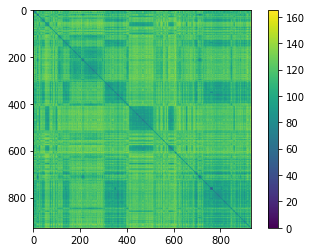

In [14]:
plt.imshow(dist)
plt.colorbar()

# III. Graph generation and plotting

In [15]:
# Create graph object
g = ig.Graph.Weighted_Adjacency(W,mode='undirected',attr='distance',loops=False)

## III.1 Node metadata

In [16]:
# Assigns a cluster value based on connected subgraphs. Useful for spring weight
g.vs['cluster'] = DF.loc[:,'group_'+seq_col]
g.vs['freq'] = DF.loc[:,'freq_'+seq_col]

### III.1.1 Node color
Define the fields `plot_label`, which will be the label in the legend of the plot, and `color` for each node. Depending on the type of label, the colouring and the labels will be different.

In [17]:
if custom_color:
    label2RGB = {}
    with open(custom_color) as file:
        for line in file:
            (key, value) = line.strip().split(',')
            if key in DF.loc[:,color_col].astype(str).values:
                label2RGB[int(key)] = tuple(v/255 for v in getcolor(value,'RGB'))
    n_colors = len(label2RGB)
    g.vs['color'] = DF.loc[:,color_col].map(label2RGB.get).values
elif color_col:
    color_label = DF.loc[:,color_col].values
    ## COLOR PALETTE ##
    # Define unique group labels
    _, idx = np.unique(color_label,return_index=True)
    labs = color_label[np.sort(idx)]
    n_colors = len(labs)
    # Create color pallete based on number of groups
    pal = ig.drawing.colors.ClusterColoringPalette(n_colors)
    label2RGB = {l:pal.get_many(c)[0] for c,l in enumerate(np.sort(labs))} # Numbering each label
    g.vs['color'] = [label2RGB[l] for l in color_label]
else:
    n_colors = 0

In [18]:
label2RGB

{'OP254': (1.0, 0.0, 0.0, 1.0),
 'OP268': (0.0, 1.0, 0.0, 1.0),
 'OP272': (0.0, 0.0, 1.0, 1.0),
 'OP273': (1.0, 1.0, 0.0, 1.0),
 'OP274': (1.0, 0.0, 1.0, 1.0)}

In [19]:
g.get_vertex_dataframe()

,cluster,freq,color
vertex ID,,,
0,0,3,"(1.0, 1.0, 0.0, 1.0)"
1,0,3,"(1.0, 1.0, 0.0, 1.0)"
2,0,3,"(1.0, 1.0, 0.0, 1.0)"
3,1,3,"(1.0, 1.0, 0.0, 1.0)"
4,1,3,"(1.0, 1.0, 0.0, 1.0)"
...,...,...,...
925,11,1,"(1.0, 1.0, 0.0, 1.0)"
926,11,1,"(1.0, 1.0, 0.0, 1.0)"
927,11,1,"(1.0, 0.0, 1.0, 1.0)"


### III.1.2 Node shape

In [20]:
if shape_col == None:
    g.vs['shape'] = 'circle'
    n_shapes = 0
else:
    shapes = ['circle','rectangle','triangle-up','triangle-down','diamond']
    funcs = [draw_circle,draw_square,draw_triangle_up,draw_triangle_down,draw_diamond]
    shape_labels = DF[shape_col].unique()
    n_shapes = len(shape_labels)
    if n_shapes > 5:
        raise ValueError('There can not be more than 5 shapes.')
    else:
        shapes = shapes[:n_shapes]
        shape_dic = {shape_labels[i]:shapes[i] for i in range(n_shapes)}
    g.vs['shape'] = DF.loc[:,shape_col].replace(shape_dic)

### III.1.3 Node size

In [21]:
if size_col==None:
    S = unit/5
else:
    S = DF[size_col].values
    S = (S-np.min(S))/(np.max(S)-np.min(S))*(max_node_size-min_node_size)+min_node_size
g.vs['size'] = S

## III.2 Edge metadata

In [22]:
g.es['color'] = ["black" if (edge['distance']>0.1 ) else "red" for edge in g.es]

In [23]:
g.get_edge_dataframe()

,source,target,distance,color
edge ID,,,,
0,0,1,0.1,red
1,0,2,0.1,red
2,1,2,0.1,red
3,3,4,0.1,red
4,3,5,0.1,red
5,4,5,0.1,red
6,6,7,0.1,red
7,6,8,0.1,red
8,7,8,0.1,red


### Graph layout
Creates a layout with the algorithm given by the keyword `layout_name` 

In [24]:
# Initialize layout with a seed (reproducibility)
random.seed(42)
np.random.seed(42)
layout_seed = np.random.random([len(g.vs),2])

# ToDo: Implement MDS and LgL

In [25]:
# Reingold-Fruchterman
if layout_name == 'FR':
    niter = 5000
    weights = kxs.prop_log_weights(g)
    g.es['weights'] = weights
    l = g.layout_fruchterman_reingold(weights=weights,\
                                      seed=layout_seed,niter=niter)
# Davidson-Harel
elif layout_name == 'DH':
    maxiter = 80
    fineiter = 15
    cool_fact = 0.95
    weight_node_dist = 1000
    weight_border = 20000000
    weight_edge_lengths = 0.1
    weight_edge_crossings = 1000
    weight_node_edge_dist = 10000
    l = g.layout_davidson_harel(seed=layout_seed, maxiter=maxiter, fineiter=fineiter,\
                                       cool_fact=cool_fact, weight_node_dist=weight_node_dist,\
                                       weight_border=weight_border,\
                                       weight_edge_lengths=weight_edge_lengths,\
                                       weight_edge_crossings=weight_edge_crossings,\
                                       weight_node_edge_dist=weight_node_edge_dist)
# Graphopt
elif layout_name == 'GO':
    niter = 500
    node_charge = 0.03
    node_mass = 5
    spring_length = 5
    spring_constant = 0.5
    max_sa_movement = 12
    l = g.layout_graphopt(niter=niter, node_charge=node_charge, node_mass=node_mass,\
                          spring_length=spring_length, spring_constant=spring_constant,\
                          max_sa_movement=max_sa_movement, seed=layout_seed)

In [26]:
g.get_vertex_dataframe()

,cluster,freq,color,shape,size
vertex ID,,,,,
0,0,3,"(1.0, 1.0, 0.0, 1.0)",circle,20.0
1,0,3,"(1.0, 1.0, 0.0, 1.0)",circle,20.0
2,0,3,"(1.0, 1.0, 0.0, 1.0)",circle,20.0
3,1,3,"(1.0, 1.0, 0.0, 1.0)",circle,20.0
4,1,3,"(1.0, 1.0, 0.0, 1.0)",circle,20.0
...,...,...,...,...,...
925,11,1,"(1.0, 1.0, 0.0, 1.0)",rectangle,20.0
926,11,1,"(1.0, 1.0, 0.0, 1.0)",circle,20.0
927,11,1,"(1.0, 0.0, 1.0, 1.0)",circle,20.0


#### Plot generation

In [27]:
# IV. Plot generation
if legend:
    label_h = 0.5*unit
    size = 0.25*unit
    width,height = (24*unit,18*unit)
    # Construct the plot
    plot = ig.Plot(out_file, bbox=(width,height), background="white")
    plot.add(g, bbox=(1*unit, 1*unit, width-7*unit, height-1*unit),layout=l,
             vertex_size=g.vs['size'])
    plot.redraw()
    ctx = cr.Context(plot.surface)
    # Legend rectangle
    n_labels = n_colors + bool(color_col)*1 + n_shapes + bool(shape_col)*1 + 3*bool(size_col)
    rect_height = label_h*(n_labels)
    rect_width = 3*unit # Change if the label is too long/short
    coord = (19*unit,9*unit-rect_height/2) # standing coordinates x,y
    ctx.rectangle(coord[0],coord[1], rect_width, rect_height)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill_preserve()
    ctx.set_source_rgb(0, 0, 0)
    ctx.set_line_width(2)
    ctx.stroke()
    # Legend items
    coord=(coord[0]+label_h,coord[1] + label_h)
    # Shape items
    if shape_col:
        for s in range(n_shapes):
            funcs[s](ctx,coord,size)
            coord = (coord[0] + 1.5*size,coord[1]+0.85*size)
            draw_text(ctx,str(shape_labels[s]),coord,size)
            coord = (coord[0]-1.5*size,coord[1]+1.15*size)
        coord = (coord[0],coord[1]+size)
    # Color items
#     if custom_color:
#         for k,v in val2col.items():
#             #RGB = getcolor(v, "RGB")
#             draw_circle(ctx,coord,size,in_color=(v[0],v[1],v[2]),
#                        line_color=(v[0],v[1],v[2]))
#             coord = (coord[0]+1.5*size,coord[1]+0.85*size)
#             draw_text(ctx,str(k),coord,size)
#             coord = (coord[0]-1.5*size,coord[1]+1.15*size)
#         coord = (coord[0],coord[1]+size)
    if color_col:
        for l,v in label2RGB.items():
            draw_circle(ctx,coord,size,in_color=(v[0],v[1],v[2]),
                       line_color=(v[0],v[1],v[2]))
            coord = (coord[0]+1.5*size,coord[1]+0.85*size)
            draw_text(ctx,str(l),coord,size)
            coord = (coord[0]-1.5*size,coord[1]+1.15*size)
        coord = (coord[0],coord[1]+size)
    # Size items
    if size_col:
        coord= (coord[0]+0.25*size,coord[1]+0.25*size)
        draw_circle(ctx,coord,min_node_size)
        coord = (coord[0]+4.5*size,coord[1]+0.6*size)
        draw_text(ctx,str(DF[size_col].min()),coord,size)
        
        coord = (coord[0]-6.25*size,coord[1]+1.15*size)
        draw_circle(ctx,coord,max_node_size,line_width = 0.05*size)
        coord = (coord[0]+3*label_h,coord[1]+label_h)
        draw_text(ctx,str(DF[size_col].max()),coord,size)
    # Save the plot
    plot.save()
else:
    visual_style = {
        'bbox' : (0, 0, 600, 600),
        'layout' : l,
        "margin": 20,
        "autocurve" : False
        #'edge_width' : g.es['width'],
    }
    ig.plot(g,target=out_file,**visual_style)